# Leafs

[Dataset from Kaggle](https://www.kaggle.com/c/leaf-classification), the goal here is to play with visualisation, PCA and ensemble methods.

The dataset comes with a set of images and a list of features (more details on Kaggle's page).

---------------------------

### 0) Setup


To download and prepare all the data (server-side):

```
mkdir data; cd data
wget https://www.kaggle.com/c/5408/download/[train/test].csv.zip #you must be logged
wget https://www.kaggle.com/c/5408/download/images.zip
unzip "*.zip"
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')   #probably won't be used here

In [2]:
train.shape, test.shape

((990, 194), (594, 193))

----------

Some helper slices:

In [3]:
margin = slice(2,66)
shape = slice(66,130)
texture = slice(130,None)
species = slice(1,1)

In [4]:
from matplotlib import cm
colmap = cm.get_cmap('cool', 30)

# 1) Reduction dimensionality

In [5]:
train.head(3)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.0,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.0,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.0,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930


In [6]:
classes = train["species"].value_counts()

count=len(classes)
avg=classes[:].mean()
std=classes[:].std()

print("{0} classes with {1} (+/-{2}) instances per class,".format(count, avg, std))
print("{0} training instances with {1} features.".format(len(train), train.shape[1]))

99 classes with 10.0 (+/-0.0) instances per class,
990 training instances with 194 features.


That's not great, in this case we can only (try) to reduce the number of features.

Let's try to look at the correlation matrix for the *margin*, *shape* and *texture* features groups.

In [7]:
def corr_sub_plot(ax, df, title=""):
    corr = df.corr()
    
    avg_corr = corr.values[np.triu_indices_from(corr.values,1)].mean()
    ax.set_title(title+" ({0:.4})".format(avg_corr))
    labels=range(1,len(corr.columns),4)
    ax.set_yticks(labels)
    ax.set_yticklabels(labels)
    return ax.imshow(corr, interpolation="nearest", cmap=colmap, vmin=-1, vmax=1)

# Colors of correlations matrices are not the same

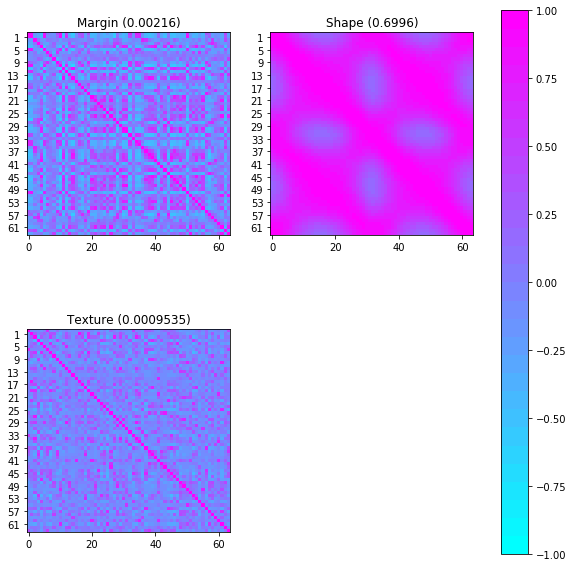

In [8]:
f, ax = plt.subplots(2, 2,figsize=(10,10))

corr_sub_plot(ax[0,0], train.iloc[:,margin], title="Margin")
corr_sub_plot(ax[0,1], train.iloc[:,shape], "Shape")
cax = corr_sub_plot(ax[1,0], train.iloc[:,texture], "Texture")

f.colorbar(cax, ax=ax.ravel().tolist())

ax[1,1].set_visible(False)

We printed in parenthesis the average correlation coefficient of the upper right triangle for each sub sets.

- **Margin**: features in the center seems to be more correlated than those on the edges, forming highly positives and negatives correlated rectangular areas.
- **Shapes**: features next to each others are highly correlated (pink), sounds reasonable. 
- **Texture**: more sporadic than the margin and shape.

-----------------


We can try to reduce the number of features through principal component analysis (PCA). Since PCA tries to maximize the variance, we need to normalize the data.

In [9]:
from sklearn.preprocessing import StandardScaler

texture_n = StandardScaler().fit_transform(train.iloc[:,texture])
shape_n = StandardScaler().fit_transform(train.iloc[:,shape])
margin_n = StandardScaler().fit_transform(train.iloc[:,margin])

In [10]:
from sklearn.decomposition import PCA

def pca_variance(data, keeped_variance):
    pca = PCA(n_components=keeped_variance)
    proj_margin =pca.fit_transform(data)
    return pca.n_components_

In [11]:
pca_red = "PCA reduced 65 features to {0}, preserving {1}% of the input's variance "
print(pca_red.format(pca_variance(texture_n, 0.95), 0.95))
print(pca_red.format(pca_variance(texture_n, 0.99), 0.99))

PCA reduced 65 features to 40, preserving 0.95% of the input's variance 
PCA reduced 65 features to 56, preserving 0.99% of the input's variance 


Let's plot the number of dimensions in function of the proportion of variance we want to preserve from the original datasets (`n_components`).

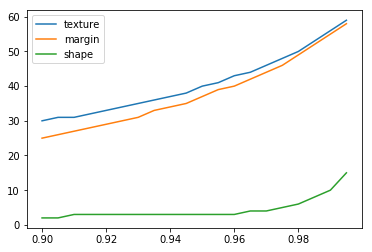

In [12]:
ranger = np.arange(0.90, 1, 0.005)
dims_texture = [pca_variance(texture_n, e) for e in ranger]
dims_margin = [pca_variance(margin_n, e) for e in ranger]
dims_shape = [pca_variance(shape_n, e) for e in ranger]

plt.plot(ranger, dims_texture, label="texture")
plt.plot(ranger, dims_margin, label="margin")
plt.plot(ranger, dims_shape, label="shape")
plt.legend(loc='upper left')

Since shapes are highly correlated in a regular way, it's easier for PCA to reduce dimensionality efficiently.
We can try to reduce dimensions to 2 and draw the result (for fun).

In [13]:
from sklearn.manifold import TSNE

pre_X = np.concatenate([texture_n, margin_n, shape_n], axis=1)
X_reduced = TSNE(n_components=2, random_state=4422, init="pca").fit_transform(pre_X)

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# cat = CategoricalEncoder(encoding="ordinal")  # waiting next sklearn update
labels = le.fit_transform(train.iloc[:, 1])

We link together all instances from the same class.

(-49.61811542510986,
 52.014328956604004,
 -48.66847915649414,
 52.606665802001956)

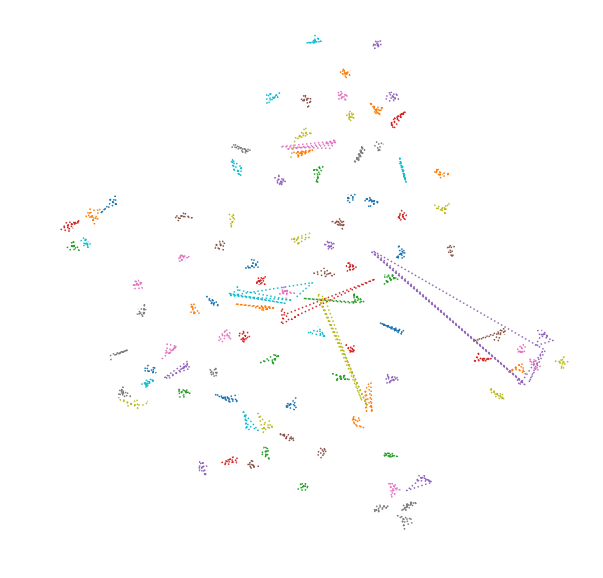

In [15]:
plt.figure(figsize=(10,10))

for i in range(0,99):
    keeped= labels == i
    plt.plot(X_reduced[keeped, 0], X_reduced[keeped, 1], linestyle=':')

plt.axis('off')

Since we are projeting a 200ish dimensional space into two, it can be worse. Most of the classes are regrouped together, even if PCA's job is not to do so !

We can also compute `TSNE` in 3D.

In [16]:
X_reduced_3D = TSNE(n_components=3, random_state=4422).fit_transform(pre_X)

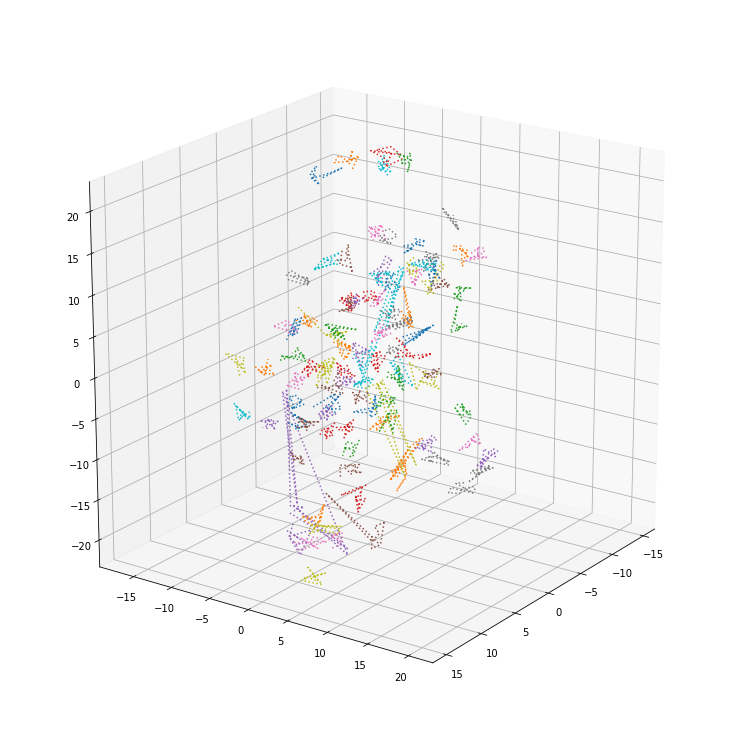

In [17]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

#in order to interact with 3D plots
#%matplotlib notebook 

for i in range(0,99):
    keeped= labels == i
    ax.plot(X_reduced_3D[keeped, 0], X_reduced_3D[keeped, 1], X_reduced_3D[keeped, 2], linestyle=':')

ax.view_init(20, 35)


----------------

### Images

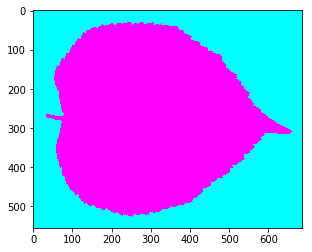

In [18]:
import matplotlib.image as mimg

plt.figure(1)
img = mimg.imread('./data/images/99.jpg')
plt.imshow(img, cmap=colmap)  # show me the leaf

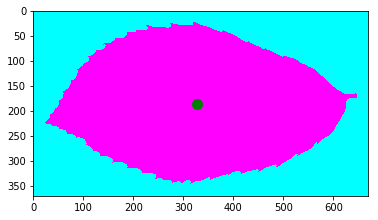

In [52]:
from skimage.feature import *
import scipy.ndimage as ndimage
from scipy.ndimage.morphology import binary_erosion, generate_binary_structure


fig, ax = plt.subplots()

# 130, 12 are nice
img_to_process = ndimage.binary_erosion(mimg.imread('./data/images/90.jpg'), structure=np.ones((2,2)))

center_of_mass = ndimage.measurements.center_of_mass(img_to_process)

coords = corner_peaks(corner_harris(img_to_process, k=0), min_distance=4)
coords_subpix = corner_subpix(img_to_process, coords, alpha=0.2)

ax.imshow(img_to_process, interpolation='nearest', cmap=colmap)

# the extraction of sharp edges is still in progress
# ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+w', markersize=15) 
ax.plot(center_of_mass[1], center_of_mass[0],'og', markersize=10)

plt.show()

We can try to use the center of mass's coordinates (divided by width and height of the image) as a feature. But we won't do it in this version.

# 2) Preparation

We first build the pipeline.

`SliceSelector` is a [transformer](http://scikit-learn.org/stable/data_transforms.html). It job is to simply select the desired columns in the data frame.

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class SliceSelector(BaseEstimator, TransformerMixin):
    def __init__(self, slice):
        self.slices = slice
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.iloc[:,self.slices]

In [21]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

def make_num_pipeline(slices, pca_coef):
    return Pipeline([('cursor', SliceSelector(slices)), 
                     ('scaler', StandardScaler()), 
                     ('PCA', PCA(n_components=pca_coef)),])

margin_pipeline = make_num_pipeline(margin, 0.96)
shape_pipeline = make_num_pipeline(shape, 0.98)
texture_pipeline = make_num_pipeline(texture, 0.96)

In [22]:
full_pipeline = FeatureUnion(transformer_list=[
    ("margin_pipeline", margin_pipeline),
    ("shape_pipeline", shape_pipeline),
    ("texture_pipeline", texture_pipeline),
])

In [23]:
y = labels
X = full_pipeline.fit_transform(train)

Since there's only ten instances per class we have to be carefull while picking instances randomly for the test/train set generation. 

`StratifiedShuffleSplit` will help us preserve the class distribution after the test/train split.

In [24]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index],  y[test_index]

# 3) Classification

We can now try to classify, we will test `KNeighbors`, `RandomForest` and `SVC` for the classification.

We also want to keep track of the accuracy and the cross-entropy loss to measure performance. We also want the cross-entropy because we want to measure the confidence of the classifer in its predictions. Partly because the test set is 20% of the total, which means that we'll have 2 instances per class in the testing set.

In [25]:
from sklearn.metrics import accuracy_score, log_loss
def fast_tests(clf, X, y, power=1):
    preds = clf.predict(X_test)
    acc = accuracy_score(y, preds)
    logloss = log_loss(y_test, np.power(clf.predict_proba(X_test), power), labels=y)
    return acc, logloss

### KNeighbors

In [26]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(weights="distance",n_jobs=-1, p=2)
neigh.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='distance')

In [27]:
fast_tests(neigh, X_test, y_test)

(0.9747474747474747, 0.09199214227710083)

In [28]:
param_dist = {"n_neighbors": range(4,10),
              "weights":["distance"],
             "leaf_size": range(1,10),
             }
rnd_n = RandomizedSearchCV(KNeighborsClassifier(p=2), param_dist, n_jobs=-1, n_iter=20)

rnd_n.fit(X_train, y_train) 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_neighbors': range(4, 10), 'weights': ['distance'], 'leaf_size': range(1, 10)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [29]:
optimized_neigh = rnd_n.best_estimator_
print(optimized_neigh)
fast_tests(optimized_neigh, X_test, y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=7, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')


(0.9848484848484849, 0.07122541114626893)

### RandomForest Classifier

Random forest don't require scaling, but it's already done in the pipeline.

In [43]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=28, n_estimators=500,random_state=0, max_features=20, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=28, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [44]:
fast_tests(forest, X_test, y_test)

(0.9797979797979798, 0.8179992501800933)

- Since we have few instances per class, we enable bootstraping; ie, random instances are sampled and replaced in the dataset.
- Since it's a classification problem, we allow `RandomizedSearchCV` search the minimum samples per leaf at 1 (default) and minimul sample split at 2.
- The cell below might take half an hour on a regular CPU.

In [34]:
from scipy.stats import randint as sp_randint
param_dist = {"max_depth": sp_randint(20, 30),
              "max_features": sp_randint(15, 60),
              "min_samples_split": sp_randint(2, 10),
             }
forest=RandomForestClassifier(n_jobs=-1, random_state=4422, bootstrap=True, criterion="entropy", n_estimators=600)
rnd_f = RandomizedSearchCV(forest, param_dist, n_iter=15, n_jobs=-1)

rnd_f.fit(X_train, y_train) 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=4422, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=15, n_jobs=-1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1725d0ad30>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1725d0ae48>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1724980048>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [35]:
optimized_forest = rnd_f.best_estimator_
print(optimized_forest)
optimized_forest.fit(X_train, y_train) 
fast_tests(optimized_forest, X_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=26, max_features=17, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=4422, verbose=0,
            warm_start=False)


(0.9848484848484849, 0.8437887737053588)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=26, max_features=17, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=4422, verbose=0,
            warm_start=False)

### Ensemble

Then let's try to combine our optimized classifiers in an soft voting manner.

In [40]:
from sklearn.ensemble import VotingClassifier

ests = [('neigh', optimized_neigh), ('forest', optimized_forest)]
voting_clf = VotingClassifier(estimators=ests, voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('neigh', KNeighborsClassifier(algorithm='auto', leaf_size=7, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')), ('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [41]:
fast_tests(voting_clf, X_test, y_test)

/home/maxence_prevost/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(0.9848484848484849, 0.706023804150477)